# Notebook to Train and Test the Discriminator

In [4]:
%reload_ext autoreload
%autoreload 2


import pandas as pd
import os

import sklearn

import numpy as np
from sklearn import metrics

import PIL
from PIL import ImageOps


from sklearn.metrics.pairwise import cosine_similarity


from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sentence_transformers import SentenceTransformer, util
from PIL import Image
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from utils.prepareml import *
from utils.eval import *
from utils.cleanreports import *

In [5]:

clipmodel = SentenceTransformer('clip-ViT-B-32')

In [6]:
# change this for your local setting
rootpath="../"

In [7]:
#all the paths local to the dataset and images

ml_gtdir=rootpath+"fkdata/"
#mldatasetpath=rootpath+"fkdata/ML_dataset.txt"
#mldatasetpath=rootpath+"fkdata/ML_datasetrows_complete.txt"
mldatasetpath=rootpath+"fkdata/ML_datasetrows.txt"
#mldatasetpath=rootpath+"fkdata/ML_datasetrows2.txt"
img_dir =rootpath+ "fkdata/dicomimages/images_normalized/"
trainfile=ml_gtdir+"train.txt"
testfile=ml_gtdir+"test.txt"
deployfile=ml_gtdir+"correct.txt" #files for report correction
top_aidir=ml_gtdir+"reportscoring/aireports"
top_modifdir=ml_gtdir+"reportscoring/correctedreports"
toporigdir=rootpath+"fkdata/reportscoring/origreports"
topaidir=rootpath+"fkdata/reportscoring/aireports"
topcorrecteddir=rootpath+"fkdata/reportscoring/correctedreports"

In [8]:
clipmodel

SentenceTransformer(
  (0): CLIPModel()
)

## Read the basic prepared dataset of images and their corresponding sentences of fake or real from the database constructed in the notebook FakeReportGeneratorNew

In [9]:
ml_df = pd.read_csv(mldatasetpath, sep='\t')
print(len(ml_df))
ml_df.head()

26463


,Patient ID,Report Name,Images,Findings Present/Absent,sentence,Real/Fake,Method
0,331,CXR1511.txt,1511_IM-0331-1001.dcm.png,['humerus'],partially visualized orif xxxx involving the l...,Fake,Add Random Finding
1,1681,CXR3460.txt,3460_IM-1681-1001.dcm.png,['scoliosis'],arthritic changes of the skeletal structures a...,Fake,Add Random Finding
2,185,CXR1277.txt,1277_IM-0185-1001.dcm.png,['kyphosis'],there is thoracic kyphosis.,Fake,Add Random Finding
3,179,CXR1263.txt,1263_IM-0179-1001.dcm.png,['shift'],stable cardiomegaly with grossly unchanged rig...,Fake,Add Random Finding
4,1688,CXR3474.txt,3474_IM-1688-1001.dcm.png,['ribs'],deformity of multiple left anterior ribs are p...,Fake,Add Random Finding


## Forms the 3 splits for train, test, and validate/deploy (for testing improvement in report quality)
### The patient splits were created earlier during the fake report generation in FakeReportGenerator

In [10]:
#Use this for pre-loaded splits
patients_train,patients_test, patients_deploy=load_splits(trainfile,testfile,deployfile)
print(len(patients_train),len(patients_test),len(patients_deploy))

1071 357 358


In [11]:
#helper data structures to prepare the train-test vector data
distinct_images,distinctimageMap,reportImageMap = assemble_images_reports(ml_df) #the distinctimageMap ; image->patientID
distinct_sents=assemble_sentences(ml_df)
print(len(distinctimageMap))
print_k_map(distinctimageMap,5)
print_k_set(distinct_images,5)
print_k_set(distinct_sents,5)

Number of unique images= 2557
Number of unique sentences= 3163
2557
0 1511_IM-0331-1001.dcm.png 331
1 3460_IM-1681-1001.dcm.png 1681
2 1277_IM-0185-1001.dcm.png 185
3 1263_IM-0179-1001.dcm.png 179
4 3474_IM-1688-1001.dcm.png 1688
0 988_IM-2474-1001.dcm.png
1 820_IM-2351-1001.dcm.png
2 3845_IM-1945-1001.dcm.png
3 515_IM-2129-1001.dcm.png
4 2945_IM-1345-12012.dcm.png
0 bony structures and soft tissues are unremarkable.
1 degenerative changes of the thoracic spine are again seen.
2 there are no xxxx focal air space consolidations.
3 there are gastroesophageal junction and epigastric postsurgical changes.
4 stable enlarged cardiomediastinal silhouette.


## Encode the text vectors using CLIP.

In [12]:
#textindex is map of sentences->sentiD, textnames is a list of sentences, and text_vec is ther clip encoding vector of all sentences
#all vectors of sentences are generated enblock as it is one-time operation and the set of sentences is not that big.
#later we will subset this to train,test, deploy partitions
textindex,textnames,text_vec=encode_cliptext(distinct_sents,clipmodel)
len(textindex),len(textnames),len(text_vec)
print_k_set(textnames,5)

0 bony structures and soft tissues are unremarkable.
100 the heart is not enlarged.
200 there is interval placement of a xxxx on the left chest with the catheter tip in the cavoatrial junction.
300 no focal airspace opacification.
400 stable right upper lobe calcified granuloma.
500 multilevel degenerative disc disease of the thoracolumbar spine noted without acute bony abnormality.
600 xxxx scarring or atelectasis right midlung.
700 there is no focal airspace opacity.
800 the lungs appear hyperexpanded suggesting emphysema.
900 the opacity at the left lung base appears stable from prior exam.
1000 the heart size is upper limits of normal.
1100 increased interstitial lung changes with superimposed pulmonary edema.
1200 there is mild bibasilar focal atelectasis.
1300 no large consolidation, effusion, or pneumothorax.
1400 again demonstrated are biapical bullous emphysematous changes.
1500 calcified right upper lobe granuloma, unchanged.
1600 xxxx xxxx right and xxxx left pleural effusio

## Generate image encoding vectors for training and testing images
### Note that the number of images in the train or test partition can be larger than the number of patients in those partitions (multiple studies per patient)
### For this run, The number of images in the train set is 1527, and number of images in the test set is #532

In [13]:
#we are separating the vectors of images into train-test partitions because their name has a 
#patientID using which we can test for membership in train or test patient sets
#generates a 512 vector.

imgindex_train,imgnames_train,img_vec_train=create_image_arraysclip_filter(patients_train,distinctimageMap,img_dir,clipmodel)
print(len(imgindex_train),len(imgnames_train),len(img_vec_train))
imgindex_test,imgnames_test,img_vec_test=create_image_arraysclip_filter(patients_test,distinctimageMap,img_dir,clipmodel)
print(len(imgindex_test),len(imgnames_train),len(img_vec_test))
print_k_map(imgindex_test,5)
#

915
915 915 915
298
298 915 298
0 3662_IM-1821-1001.dcm.png 0
1 3110_IM-1460-1001.dcm.png 1
2 2540_IM-1052-1001.dcm.png 2
3 3272_IM-1553-1001.dcm.png 3
4 3500_IM-1706-1001.dcm.png 4


In [14]:
print(len(imgindex_train),len(imgnames_train),len(img_vec_train))
print(len(imgindex_test),len(imgnames_test),len(img_vec_test))

915 915 915
298 298 298


## We now generate a combined feature vector of image encoding and the sentence encoding.
### The list of sentences and image pairs are already available in the ML_dataset.txt which has been read as a data frame (ml_df).
### The lists of images are already filtered for the respective partitions (imgindex_train, imgindexx_test)
### So the vectors produced for the train and test splits automatically do not overlap in patients

In [15]:
xarray_train,yarray_train,recordedpairs_train=form_combined_feature_vector(ml_df,textindex,imgindex_train,text_vec,img_vec_train)
xarray_test,yarray_test,recordedpairs_test=form_combined_feature_vector(ml_df,textindex,imgindex_test,text_vec,img_vec_test)
print(len(imgindex_train), len(textindex))
print("The number of image-sentence pairs and labels in training set")
print(len(xarray_train), len(yarray_train))
print ("The number of image-sentence pairs and labels in the test set")
print(len(xarray_test), len(yarray_test))


0  out of  26463
100  out of  26463
200  out of  26463
300  out of  26463
400  out of  26463
500  out of  26463
600  out of  26463
700  out of  26463
800  out of  26463
900  out of  26463
1000  out of  26463
1100  out of  26463
1200  out of  26463
1300  out of  26463
1400  out of  26463
1500  out of  26463
1600  out of  26463
1700  out of  26463
1800  out of  26463
1900  out of  26463
2000  out of  26463
2100  out of  26463
2200  out of  26463
2300  out of  26463
2400  out of  26463
2500  out of  26463
2600  out of  26463
2700  out of  26463
2800  out of  26463
2900  out of  26463
3000  out of  26463
3100  out of  26463
3200  out of  26463
3300  out of  26463
3400  out of  26463
3500  out of  26463
3600  out of  26463
3700  out of  26463
3800  out of  26463
3900  out of  26463
4000  out of  26463
4100  out of  26463
4200  out of  26463
4300  out of  26463
4400  out of  26463
4500  out of  26463
4600  out of  26463
4700  out of  26463
4800  out of  26463
4900  out of  26463
5000  out of

##   Begin Training of the Classifier and Testing
### The classifier and all the report metrics are taken from sklearn and sklearn.metrics

In [16]:
clf = svm.SVC(kernel='linear',random_state=35,probability=True)  # Linear kernel can be replaced with other kernels like 'rbf' or 'poly'
clf.fit(xarray_train,yarray_train)

SVC(kernel='linear', probability=True, random_state=35)

In [74]:
y_pred=clf.predict(xarray_test)

In [64]:
precision,recall,f1,accuracy=binary_prscore(yarray_test,y_pred)

1429 1656 1105 324 246 1410
0.8179126572908957 0.7732680195941217 0.7949640287769785 0.8152350081037277


In [84]:
prop = clf.decision_function(xarray_test)

In [92]:
prop[0],prop[1],y_pred[0]

(-1.333843961476262, -1.2328927074148712, array([0.84068595, 0.15931405]))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


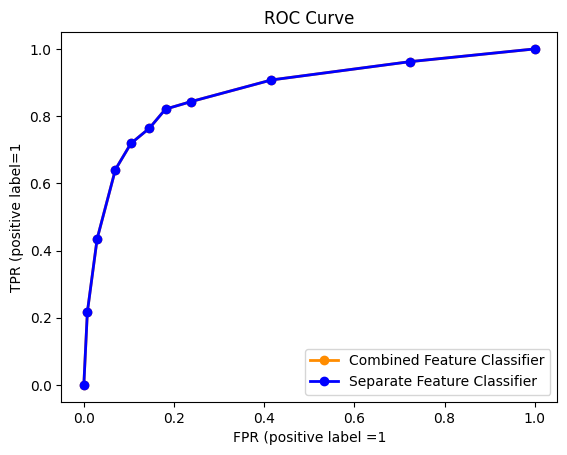

In [36]:
#for manual plotting of ROC curve
import numpy as np
y_pred=clf.predict_proba(xarray_test)
tpr,fpr,auc=compute_roc_manual(y_pred,yarray_test)
plt.plot(fpr, tpr, marker='o', color='darkorange', lw = 2, label='Combined Feature Classifier', clip_on=False)
plt.plot(fpr, tpr, marker='o', color='blue', lw = 2, label='Separate Feature Classifier', clip_on=False)
plt.legend(loc="lower right")
#plt.plot(fpr,tpr,label='ROC curve')
plt.title("ROC Curve")
plt.xlabel("FPR (positive label =1")
plt.ylabel("TPR (positive label=1")
plt.show()


In [22]:

print(tpr,fpr)
auc = -1 * np.trapz(tpr, fpr)
print(auc)

[1.0, 0.9622113365990203, 0.907627711686494, 0.8432470258922323, 0.820853743876837, 0.7641707487753674, 0.7186843946815955, 0.6410076976906928, 0.4352694191742477, 0.21693491952414276, 0.0] [1.0, 0.7240338164251208, 0.41606280193236717, 0.23792270531400966, 0.18115942028985507, 0.14553140096618358, 0.10446859903381643, 0.07004830917874397, 0.029589371980676328, 0.00785024154589372, 0.0]
0.8736549325057553


Accuracy: 0.8152350081037277
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1656
           1       0.82      0.77      0.79      1429

    accuracy                           0.82      3085
   macro avg       0.82      0.81      0.81      3085
weighted avg       0.82      0.82      0.81      3085

[[1410  246]
 [ 324 1105]]


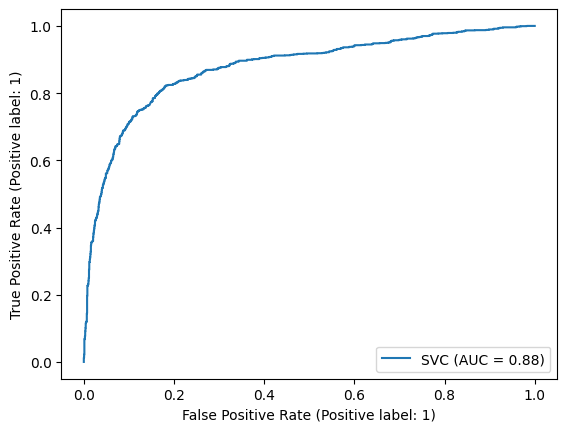

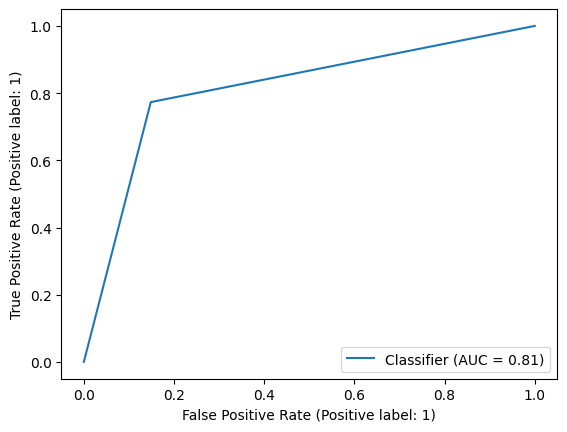

In [18]:
accuracy = accuracy_score(yarray_test, y_pred)
print("Accuracy:", accuracy)
print(metrics.classification_report(yarray_test, y_pred))
print(metrics.confusion_matrix(yarray_test, y_pred))

svc_disp = RocCurveDisplay.from_estimator(clf, xarray_test, yarray_test)
svc_disp = RocCurveDisplay.from_predictions( yarray_test,y_pred)
plt.show()

In [ ]:
record_per_findingcase(ml_df, recordedpairs_test, yarray_test, y_pred)

### Comparing to using the cosine similarity of CLIP image and text vectors to classify (i.e. by not combining them into a feature vector)

In [37]:
xarray_train,yarray_train,xsimple_train,recordedpairs_train=form_sep_vectors(ml_df,textindex,imgindex_train,text_vec,img_vec_train)
xarray_test,yarray_test,xsimple_test,recordedpairs_test=form_sep_vectors(ml_df,textindex,imgindex_test,text_vec,img_vec_test)

0  out of  26463
100  out of  26463
200  out of  26463
300  out of  26463
400  out of  26463
500  out of  26463
600  out of  26463
700  out of  26463
800  out of  26463
900  out of  26463
1000  out of  26463
1100  out of  26463
1200  out of  26463
1300  out of  26463
1400  out of  26463
1500  out of  26463
1600  out of  26463
1700  out of  26463
1800  out of  26463
1900  out of  26463
2000  out of  26463
2100  out of  26463
2200  out of  26463
2300  out of  26463
2400  out of  26463
2500  out of  26463
2600  out of  26463
2700  out of  26463
2800  out of  26463
2900  out of  26463
3000  out of  26463
3100  out of  26463
3200  out of  26463
3300  out of  26463
3400  out of  26463
3500  out of  26463
3600  out of  26463
3700  out of  26463
3800  out of  26463
3900  out of  26463
4000  out of  26463
4100  out of  26463
4200  out of  26463
4300  out of  26463
4400  out of  26463
4500  out of  26463
4600  out of  26463
4700  out of  26463
4800  out of  26463
4900  out of  26463
5000  out of

In [38]:
print(len(xsimple_train), len(yarray_train))
print(len(xsimple_test),len(yarray_test))


9531 9531
3085 3085


In [39]:
values1=set()
values0=set()
for i in range(len(yarray_test)):
    if (yarray_test[i]==1):
        values1.add(xsimple_test[i][0])
    else:
        values0.add(xsimple_test[i][0])
print(len(values1),len(values0))
#print(values1)

936 1652


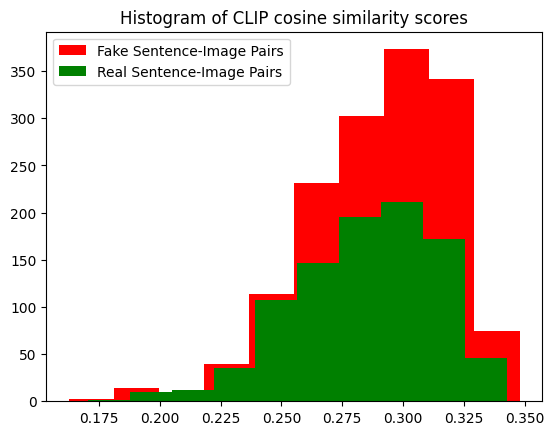

In [40]:

plt.hist(list(values0)[0:1500],color='red')
plt.hist(list(values1)[0:1500],color='green')
labels= ["Fake Sentence-Image Pairs","Real Sentence-Image Pairs"]
plt.legend(labels)
plt.title("Histogram of CLIP cosine similarity scores")
plt.show() 

In [41]:
clf2 = svm.SVC(kernel='linear',random_state=35,probability=True)  # Linear kernel can be replaced with other kernels like 'rbf' or 'poly'
clf2.fit(xsimple_train,yarray_train)

SVC(kernel='linear', probability=True, random_state=35)

In [42]:
y_pred2=clf2.predict(xsimple_test)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
AUC=  0.5359728434126766


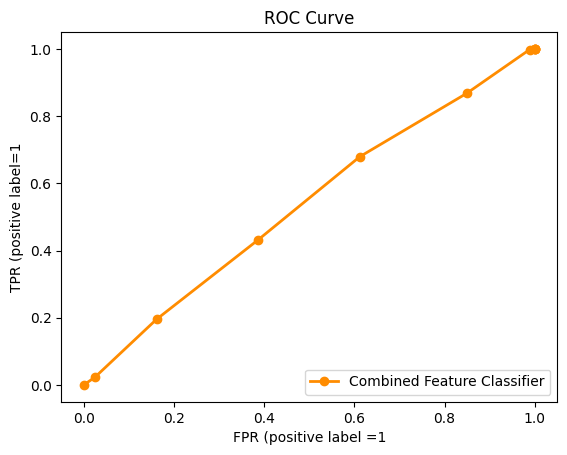

In [46]:
y_pred2=clf2.predict_proba(xsimple_test)
tpr2,fpr2,auc2=compute_roc_manual(y_pred2,yarray_test)
print("AUC= ", auc2)
plt.plot(fpr2, tpr2, marker='o', color='darkorange', lw = 2, label='Combined Feature Classifier', clip_on=False)
#plt.plot(fpr, tpr, marker='o', color='blue', lw = 2, label='Separate Feature Classifier', clip_on=False)
plt.legend(loc="lower right")
#plt.plot(fpr,tpr,label='ROC curve')
plt.title("ROC Curve")
plt.xlabel("FPR (positive label =1")
plt.ylabel("TPR (positive label=1")
plt.show()

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


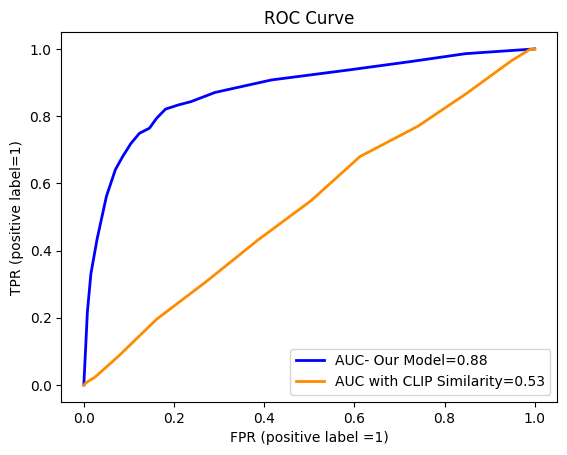

In [64]:
y_pred=clf.predict_proba(xarray_test)
tpr,fpr,auc=compute_roc_manual(y_pred,yarray_test,20)
label1str="AUC- Our Model="+"{:.2f}".format(auc)
y_pred2=clf2.predict_proba(xsimple_test)
tpr2,fpr2,auc2=compute_roc_manual(y_pred2,yarray_test,20)

label2str="AUC with CLIP Similarity="+"{:.2f}".format(auc2)
#plt.plot(fpr, tpr, marker='o', color='blue', lw = 2, label=label1str, clip_on=False)
#plt.plot(fpr2, tpr2, marker='o', color='darkorange', lw = 2, label=label2str, clip_on=False)
plt.plot(fpr, tpr,  color='blue', lw = 2, label=label1str, clip_on=False)
plt.plot(fpr2, tpr2, color='darkorange', lw = 2, label=label2str, clip_on=False)
plt.legend(loc="lower right")
#plt.plot(fpr,tpr,label='ROC curve')
plt.title("ROC Curve")
plt.xlabel("FPR (positive label =1)")
plt.ylabel("TPR (positive label=1)")
plt.show()


In [ ]:
#precision,recall,f1,accuracy=binary_prscore(yarray_test,y_pred2)
accuracy = accuracy_score(yarray_test, y_pred2)
print("Accuracy:", accuracy)
print(metrics.classification_report(yarray_test, y_pred2))
print(metrics.confusion_matrix(yarray_test, y_pred2))

svc_disp = RocCurveDisplay.from_estimator(clf2, xsimple_test, yarray_test)
svc_disp = RocCurveDisplay.from_predictions(yarray_test,y_pred2)
plt.show()

## Comparing the two methods


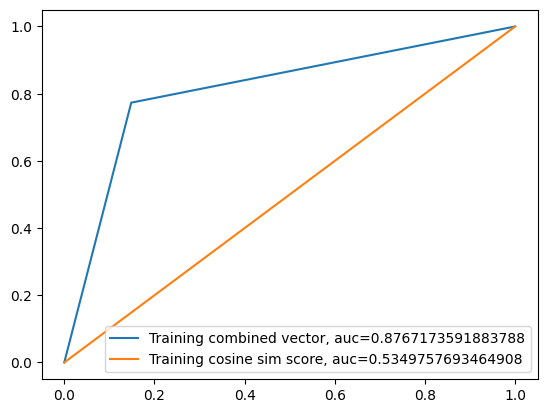

In [34]:
fpr1, tpr1, thresh1 = metrics.roc_curve(yarray_test, y_pred)
fpr2,tpr2,thresh2=metrics.roc_curve(yarray_test,y_pred2)
#auc1 = metrics.roc_auc_score(yarray_test, y_pred)
auc1=metrics.roc_auc_score(yarray_test, clf.predict_proba(xarray_test)[:, 1])
#auc2 = metrics.roc_auc_score(yarray_test, y_pred2)
auc2 = metrics.roc_auc_score(yarray_test,clf2.predict_proba(xsimple_test)[:, 1])

plt.plot(fpr1,tpr1,label="Training combined vector, auc="+str(auc1))
plt.plot(fpr2,tpr2,label="Training cosine sim score, auc="+str(auc2))
plt.legend(loc=0)

## Clean AI Reports

In [ ]:
sentencelist,imagenameslist,sentindex,imgindex,text_vec,img_vec,count_reduceMap=create_modified_reports(clf,clipmodel,topaidir,img_dir,topcorrecteddir,reportImageMap)

In [58]:
count_reduceMap

{1: 1616, 0: 698, 2: 857, 3: 360, 4: 125, 5: 45, 6: 11}

In [12]:
 allsents=extract_sentences(topaidir+"/CXR2559.txt_4")

In [13]:
print(allsents)

['The heart size and pulmonary vascularity appear within normal limits.', 'The lungs are free of focal airspace disease.', 'There is no acute infiltrate or pleural effusion.']
